In [1]:
import requests
import json
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='Blues')
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from itertools import combinations
from tqdm import tqdm
import pandas as pd
import paramiko
from paramiko import SSHClient
from scp import SCPClient
import os
from numpy.polynomial.polynomial import polyfit
from scipy.stats import t as t_dist
%matplotlib inline

### List of Experiments

In [2]:
WGAN_GP_CIFAR = 9691
WGAN_GP_MNIST = 9690
DCGAN_MNIST = 9695
DCGAN_CIFAR = 9694
NSGAN_CIFAR = 9704
NSGAN_MNIST = 9706
WGAN_GP_FASHIONMNIST = 9723
DCGAN_FASHIONMNIST = 9724
NSGAN_FASHIONMNIST = 9727
WGAN_GP_CELEBA = 9761
NSGAN_CELEBA = 9763
DCGAN_CELEBA = 9770

# Grouped by GAN-Architecture
NSGAN_ALL_DATASETS = [NSGAN_MNIST, NSGAN_FASHIONMNIST, NSGAN_CIFAR, NSGAN_CELEBA]
WGAN_GP_ALL_DATASETS = [WGAN_GP_MNIST, WGAN_GP_FASHIONMNIST, WGAN_GP_CIFAR, WGAN_GP_CELEBA]
DCGAN_ALL_DATASETS = [DCGAN_MNIST, DCGAN_FASHIONMNIST, DCGAN_CIFAR, DCGAN_CELEBA]

# Grouped by Dataset
MNIST_ALL_GANS = [NSGAN_MNIST, DCGAN_MNIST, WGAN_GP_MNIST]
FASHIONMNIST_ALL_GANS = [NSGAN_FASHIONMNIST, DCGAN_FASHIONMNIST, WGAN_GP_FASHIONMNIST]
CIFAR_ALL_GANS = [NSGAN_CIFAR, DCGAN_CIFAR, WGAN_GP_CIFAR]
CELEBA_ALL_GANS = [NSGAN_CELEBA, DCGAN_CELEBA, WGAN_GP_CELEBA]

ALL_EXPERIMENTS = [9691, 9690, 9695, 9694, 9704, 9706, 9723, 9724, 9727, 9761, 9763, 9770]

### Settings

In [3]:
EXPERIMENT_IDS = ALL_EXPERIMENTS
USERNAME = 'ldrews'
PASSWORD = ''
BASE_URL = 'https://dt1.f4.htw-berlin.de:8443'
# Für den Download der Bilder von diesem Server muss eine Verbindung zum internen Hochschulnetz bestehen
IMAGES_URL = 'avocado01.f4.htw-berlin.de'

### API URLs

In [4]:
login_url = '/api/v1/auth/login'
logout_url = '/api/v1/auth/logout'
get_trialId = lambda experimentId: f'/api/v1/experiments/{experimentId}/trials'
get_trial_url = lambda trialId: f'/api/v1/trials/{trialId}'
get_experiment_url = lambda experimentId: f'/api/v1/experiments/{experimentId}'
get_trials_of_experiment_url = lambda experimentId: f'/api/v1/experiments/{experimentId}/trials'

### Helper functions and classes

In [5]:
class Experiment:
    description: str
    labels: list
    name: str
    dataset: str
    experiment_id: int
    trials: list
    hyperparameters: list
    def __init__(self, experiment_id, description=None, labels=[], name=None, dataset=None, hyperparameters=None):
        self.experiment_id = experiment_id
        self.description = description
        self.labels = labels
        self.name = name
        self.dataset = dataset
        self.trials = []
        self.hyperparameters = hyperparameters
        
    def __str__(self):
        return f'Experiment Id: {self.experiment_id}, name: {self.name}'

In [6]:
class Trial:
    trial_id: int
    training_metrics: list
    training_metric_labels: list
    validation_metrics: list
    number_of_batches: int
    def __init__(self, trial_id, number_of_batches, training_metrics=None, validation_metrics=None, training_metric_labels=None):
        self.trial_id = trial_id
        self.training_metrics = training_metrics
        self.validation_metrics = validation_metrics
        self.training_metric_labels = training_metric_labels
        self.number_of_batches = number_of_batches
    
    def __str__(self):
        return f'Trial Id: {self.trial_id}'

In [7]:
class Metric:
    name: str
    steps: list
    data: list
    def __init__(self, name, steps, data):
        self.name = name
        self.steps = steps
        self.data = data
        
    def __str__(self):
        return f'Metric {self.name}'

In [8]:
def load_and_display_images(paths, figsize=(16, 10)):
    imgs = []
    for name, p in paths:
        try:
            img = torch.load(p, map_location=torch.device('cpu')).detach()
            img = make_grid(img[0:32])
            img = img.permute(1, 2, 0)
            imgs.append((name, img))
        except FileNotFoundError:
            print(f'Couldn\'t load images from path {p}')
           
        
    if len(imgs) > 0:
        fig = plt.figure(figsize=figsize)
        columns = 2
        rows = calculate_number_of_rows(len(imgs), 2)
        for i, (name, e) in enumerate(imgs):
            ax = fig.add_subplot(rows, columns, i+1)
            ax.set_title(f'{name}')
            plt.axis('off')
            plt.imshow(e)

In [9]:
def download_file(url, username, password, path, experiment_id, file_name, local_path='.'):
    try:
        with SSHClient() as ssh:
            ssh.load_system_host_keys()
            ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
            ssh.connect(url, username=username, password=password)

            with SCPClient(ssh.get_transport()) as scp:
                scp.get(f'{path}/{file_name}', local_path=local_path)
    except TimeoutError:
        print(f'Couldn\'t connect to url {url}')

In [10]:
def download_images(experiment_id, file_name, local_path='.', rename=False, new_name=None):
    path = f'/data/determined/shared_fs/imgs/experiment{experiment_id:0>5}/'
    download_file(url=IMAGES_URL, username=USERNAME, password=PASSWORD,
                         path=path, experiment_id=experiment_id, file_name=file_name, local_path=local_path)
    
    os.makedirs(local_path, exist_ok=True)
    if rename and new_name is not None:
        if local_path[-1] != '/':
            local_path = local_path + '/'
        try:
            os.rename(f'{local_path}{file_name}', new_name)
        except FileExistsError:
            print(f'File {new_name} does already exist')

In [11]:
def calculate_number_of_rows(number_of_plots, number_of_cols):
    if number_of_plots % number_of_cols == 0:
        return number_of_plots // number_of_cols
    else: 
        return number_of_plots // number_of_cols + 1

### Determined AI Authentification

In [12]:
# Authenticate 
login_body = json.dumps({
    'username': f'{USERNAME}', 
    'password': f'{PASSWORD}'
    }).encode('utf-8')

login_headers = {
    'Content-Type': 'application/json',
    'accept': 'application/json',
}

response = requests.post(url=f'{BASE_URL}{login_url}', data=login_body, headers=login_headers)
if response.status_code == 200:
    print('authenticated')
    authenticated = True
    data = response.json()
    
    authenticated_headers = {
    'Content-Type': 'application/json',
    'accept': 'application/json',
    'Authorization': f'Bearer {data["token"]}',
    }

authenticated


In [13]:
def get_experiment_data(experiment_id):
    with requests.get(
        url=f'{BASE_URL}{get_experiment_url(experiment_id)}',
        headers=authenticated_headers) as response:
        if response.status_code == 200:
            data = response.json()
            description = data['experiment']['description']
            labels = data['experiment']['labels']
            name = data['experiment']['name']
            dataset = None
            try:
                dataset = data['config']['data']['dataset']
            except KeyError:
                print("Couldn't find dataset in config")
            hyperparameters = data['config']['hyperparameters']
            hyperparameters = {x[0]: x[1]['val'] for x in hyperparameters.items()}
            return Experiment(experiment_id, description=description, labels=labels, name=name, dataset=dataset, hyperparameters=hyperparameters)

In [14]:
def get_trial_ids_of_experiment(experiment_id):
    with requests.get(
    url=f'{BASE_URL}{get_trials_of_experiment_url(experiment_id)}',
    headers=authenticated_headers) as response:
        if response.status_code == 200:
            data = response.json()
            trial_ids = [trial['id'] for trial in data['trials']]
            return trial_ids

In [15]:
def get_trial_data(trial_id):
    with requests.get(
    url=f'{BASE_URL}{get_trial_url(trial_id)}',
    headers=authenticated_headers) as response:
        if response.status_code == 200:
            data = response.json()
            validation_metrics = data['trial']['bestValidation']['metrics']

            training_steps = [step['training'] for step in data['workloads'] if 'training' in step]
            training_metrics_data = [(x['totalBatches'], x['metrics']) for x in training_steps]
            training_metric_labels = list(training_metrics_data[0][1].keys())
            number_of_batches = max([x[0] for x in training_metrics_data])
            #print(training_metrics_data)
            
            training_metrics = dict()
            batch_steps, data = zip(*training_metrics_data)
            
            for l in training_metric_labels:
                metric_data = [x[l] for x in data]
                training_metrics[l] = Metric(name=l, steps=batch_steps, data=metric_data)
                
            return Trial(trial_id, 
                         number_of_batches=number_of_batches,
                         training_metrics=training_metrics, 
                         validation_metrics=validation_metrics, 
                         training_metric_labels=training_metric_labels)

### Get data of all experiments

In [16]:
experiments = []

In [17]:
if authenticated:
    for exp_id in tqdm(EXPERIMENT_IDS):
        experiment = get_experiment_data(exp_id)
        if experiment is not None:
            experiments.append(experiment)
    
    for exp in tqdm(experiments):
        trial_ids = get_trial_ids_of_experiment(exp.experiment_id)
        for trial_id in trial_ids:
            trial = get_trial_data(trial_id)
            if trial is not None:
                exp.trials.append(trial)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:52<00:00,  4.34s/it]


## Overview

In [18]:
names = []
datasets = []
descriptions = []
hyperparameter_names = set()
hyperparameters = []

for e in experiments:
    names.append(e.name)
    datasets.append(e.dataset if e.dataset is not None else '')
    descriptions.append(e.description)
    for n in e.hyperparameters.keys():
        hyperparameter_names.add(n)
        
for e in experiments:
    hp = []
    for n in hyperparameter_names:
        hp.append(e.hyperparameters[n] if n in e.hyperparameters.keys() else '')
    hyperparameters.append(hp)

data = list(zip(datasets, hyperparameters))
data = list(map(lambda x: [x[0], *x[1]], data))
df = pd.DataFrame(data, columns=['dataset', *hyperparameter_names])
df.index = names
df = df.reindex(sorted(df.columns), axis=1)
df

b1     b2 critic_iterations        dataset  \
WGAN-GP_FINAL_CIFAR-10      0.5  0.900                 5       cifar-10   
WGAN-GP_FINAL_MNIST         0.5  0.900                 5          mnist   
DCGAN_FINAL_MNIST           0.5  0.999                            mnist   
DCGAN_FINAL_CIFAR-10        0.5  0.999                         cifar-10   
NSGAN_FINAL_CIFAR-10        0.5  0.999                         cifar-10   
NSGAN_FINAL_MNIST           0.5  0.999                            mnist   
WGAN-GP_FINAL_FashionMNIST  0.5  0.900                 5  fashion-mnist   
DCGAN_FINAL_FashionMNIST    0.5  0.999                    fashion-mnist   
NSGAN_FINAL_FashionMNIST    0.5  0.999                    fashion-mnist   
WGAN-GP_FINAL_CELEBA        0.5  0.900                 5         celeba   
NSGAN_FINAL_CELEBA          0.5  0.999                           celeba   
DCGAN_FINAL_CELEBA          0.5  0.999                           celeba   

                           disc_iterations  evaluate_while_trainig  \
WGAN-GP_FINAL_CIFAR-10                                        True   
WGAN-GP_FINAL_MNIST                                           True   
DCGAN_FINAL_MNIST                        1                    True   
DCGAN_FINAL_CIFAR-10                     1                    True   
NSGAN_FINAL_CIFAR-10                     1                    True   
NSGAN_FINAL_MNIST                        1                    True   
WGAN-GP_FINAL_FashionMNIST                                    True   
DCGAN_FINAL_FashionMNIST                 1                    True   
NSGAN_FINAL_FashionMNIST                 1                    True   
WGAN-GP_FINAL_CELEBA                                          True   
NSGAN_FINAL_CELEBA                       1                    True   
DCGAN_FINAL_CELEBA                       1                    True   

                            global_batch_size gradient_penalty  \
WGAN-GP_FINAL_CIFAR-10                     32             True   
WGAN-GP_FINAL_MNIST                        32             True   
DCGAN_FINAL_MNIST                          32                    
DCGAN_FINAL_CIFAR-10                       32                    
NSGAN_FINAL_CIFAR-10                       32                    
NSGAN_FINAL_MNIST                          32                    
WGAN-GP_FINAL_FashionMNIST                 32             True   
DCGAN_FINAL_FashionMNIST                   32                    
NSGAN_FINAL_FashionMNIST                   32                    
WGAN-GP_FINAL_CELEBA                       32             True   
NSGAN_FINAL_CELEBA                         32                    
DCGAN_FINAL_CELEBA                         32                    

                           gradient_penaty_lambda  latent_dim      lr  
WGAN-GP_FINAL_CIFAR-10                         10         100  0.0002  
WGAN-GP_FINAL_MNIST                            10         100  0.0002  
DCGAN_FINAL_MNIST                                         100  0.0002  
DCGAN_FINAL_CIFAR-10                                      100  0.0002  
NSGAN_FINAL_CIFAR-10                                      100  0.0002  
NSGAN_FINAL_MNIST                                         100  0.0002  
WGAN-GP_FINAL_FashionMNIST                     10         100  0.0002  
DCGAN_FINAL_FashionMNIST                                  100  0.0002  
NSGAN_FINAL_FashionMNIST                                  100  0.0002  
WGAN-GP_FINAL_CELEBA                           10         100  0.0002  
NSGAN_FINAL_CELEBA                                        100  0.0002  
DCGAN_FINAL_CELEBA                                        100  0.0002

### Plot sample images

In [19]:
for e in experiments:
    download_images(e.experiment_id, 'fake.pt', local_path='/imgs/', rename=True, new_name=f'{e.experiment_id}.pt')

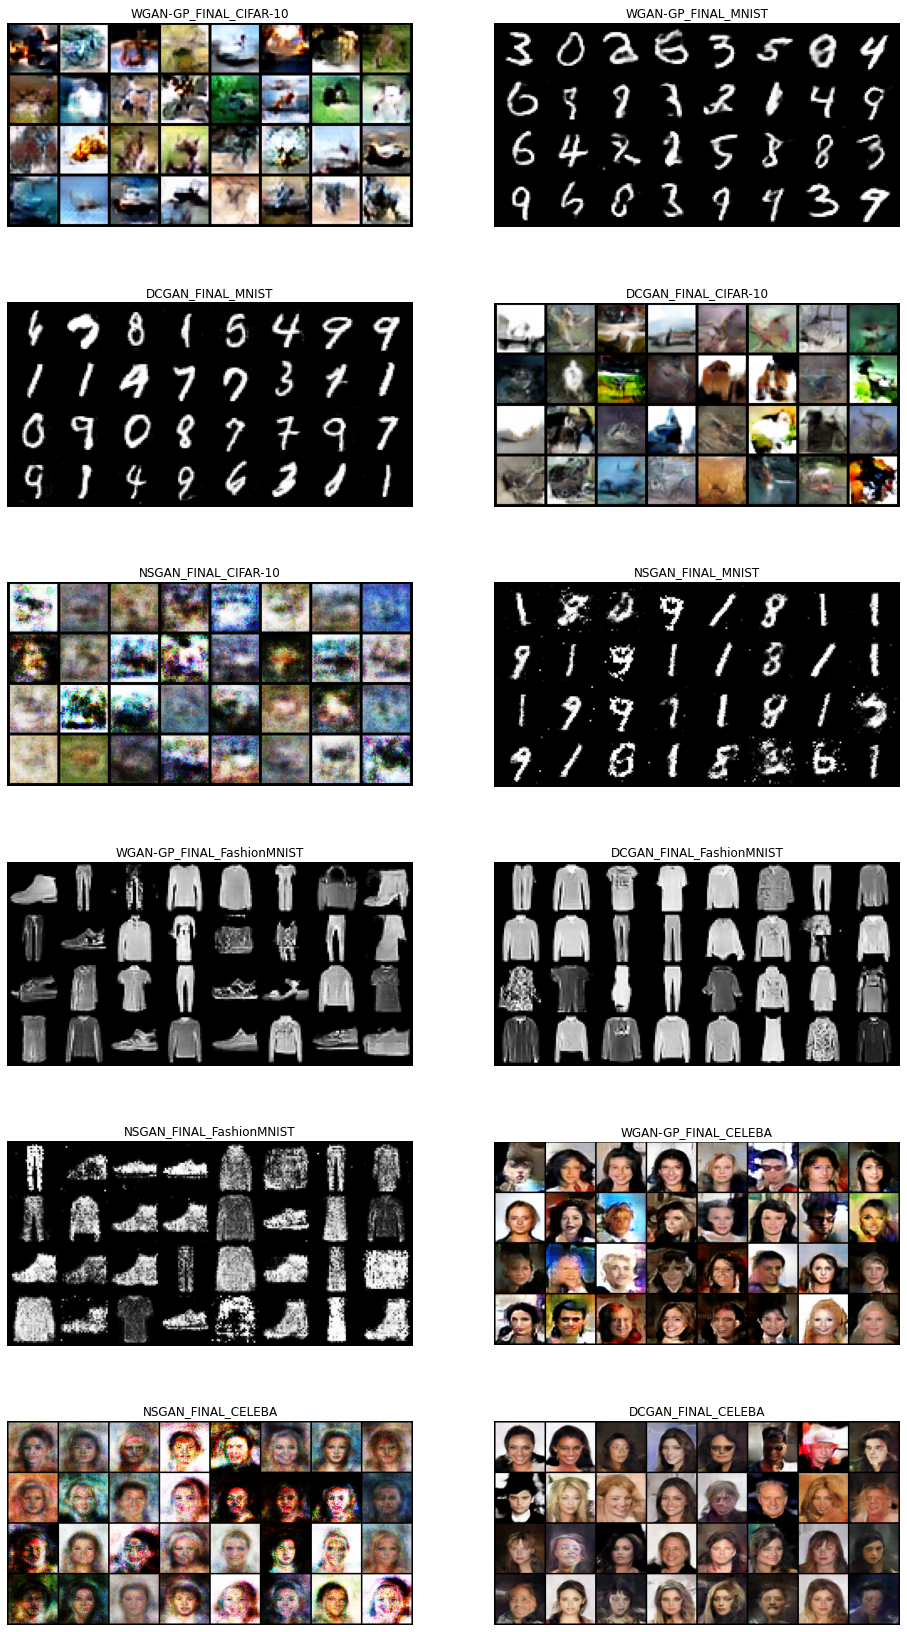

In [20]:
load_and_display_images([(e.name, f'{e.experiment_id}.pt') for e in experiments], figsize=(16, 30))

## Training

### Plot Training Metrics

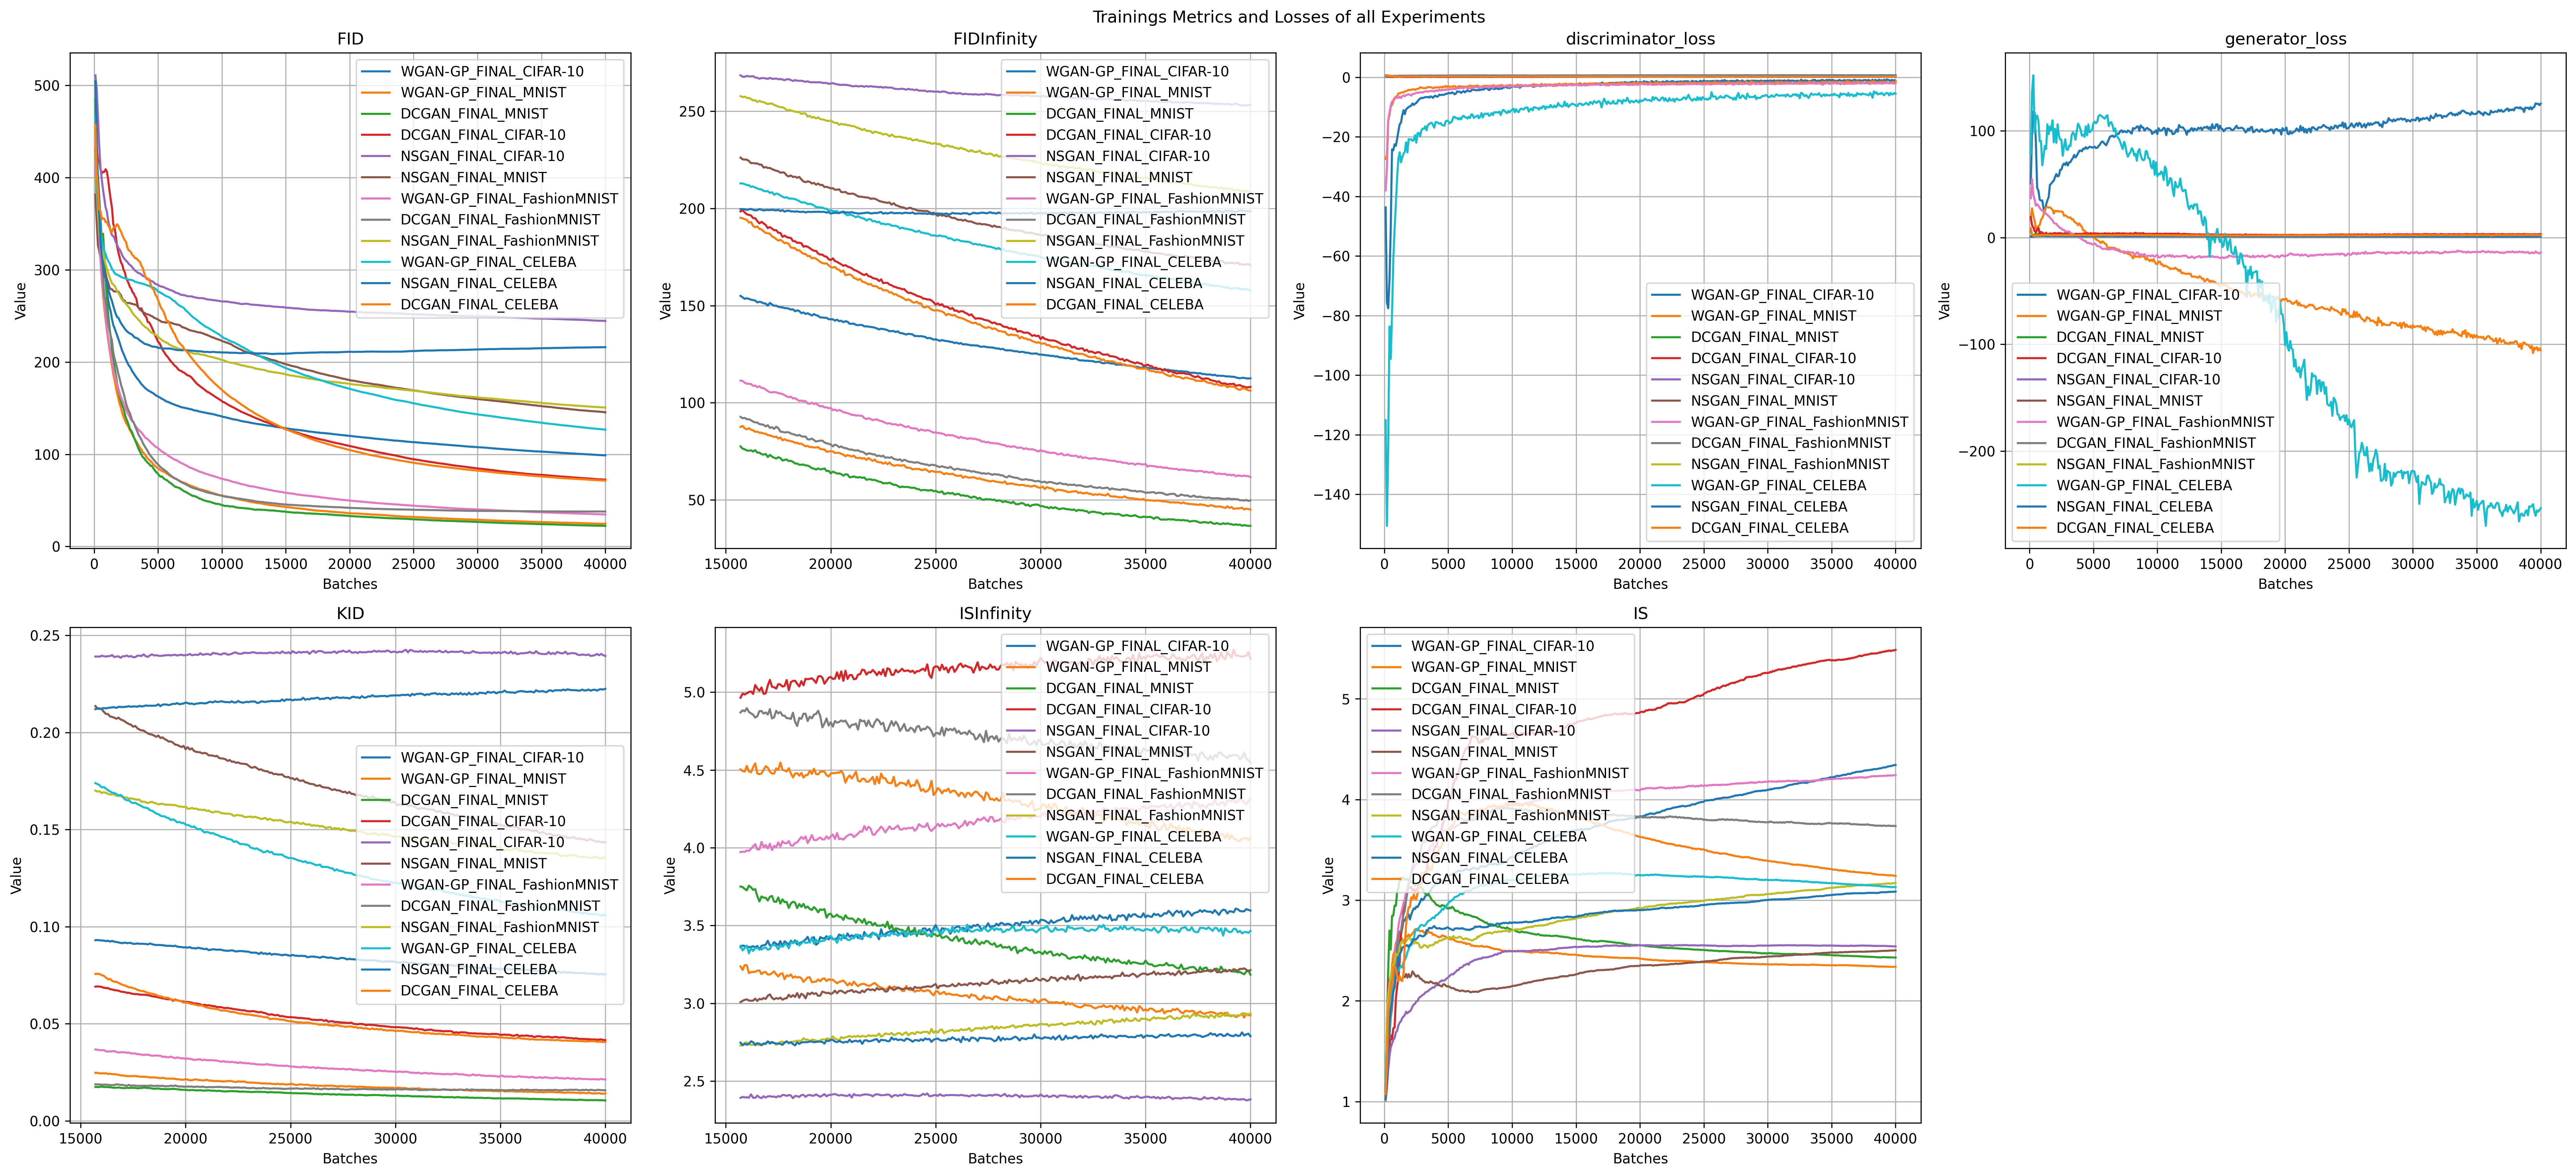

In [21]:
number_of_batches = 0
loss_labels = set()

for e in experiments:
    for t in e.trials:
        number_of_batches = max(number_of_batches, t.number_of_batches)
        for l in t.training_metric_labels:
            loss_labels.add(l)



number_of_plots = len(loss_labels)

number_of_cols = 4
if number_of_plots > 5:
    number_of_rows = calculate_number_of_rows(number_of_plots, number_of_cols)
else:
    number_of_rows = 5

    
    
fig = plt.figure(dpi=300)
fig.suptitle(f'Trainings Metrics and Losses of all Experiments')#, fontsize=200)#, y=1.005)
fig.set_size_inches(26, 12)
index = 1


for l in loss_labels:
    ax = fig.add_subplot(number_of_rows, number_of_cols, index)
    for e in experiments:
        for t in e.trials:
            if l in t.training_metrics.keys():
                ax.plot(t.training_metrics[l].steps, t.training_metrics[l].data, label=f'{e.name}')
    ax.grid(True)
    ax.legend()
    ax.set(xlabel='Batches', ylabel='Value', title=f'{l}')
    #ax.set_ylim([y_min, y_max])
    index = index + 1
fig.tight_layout()

### Create a scatterplot for every combination between metrics (and losses)

In [22]:
'''
number_of_plots = 100

number_of_cols = 4
if number_of_plots > 5:
    number_of_rows = calculate_number_of_rows(number_of_plots, number_of_cols)
else:
    number_of_rows = 5
    
for e in experiments:
    fig = plt.figure(dpi=300)
    fig.suptitle(f'Trainings Metrics and Losses of {e.name}', fontsize=200, y=1.005)
    index = 1
    for t in e.trials:
        for x, y in combinations(t.training_metric_labels, 2):
            ax = fig.add_subplot(number_of_rows, number_of_cols, index)
            ax.scatter(t.training_metrics[x].data, t.training_metrics[y].data)
            ax.set(xlabel=x, ylabel=y, title=f'{x}-{y}')
            ax.grid(True)
            index = index + 1
    fig.set_size_inches(60, 200)
    fig.tight_layout()
''';

### Correlations between Training Metrics

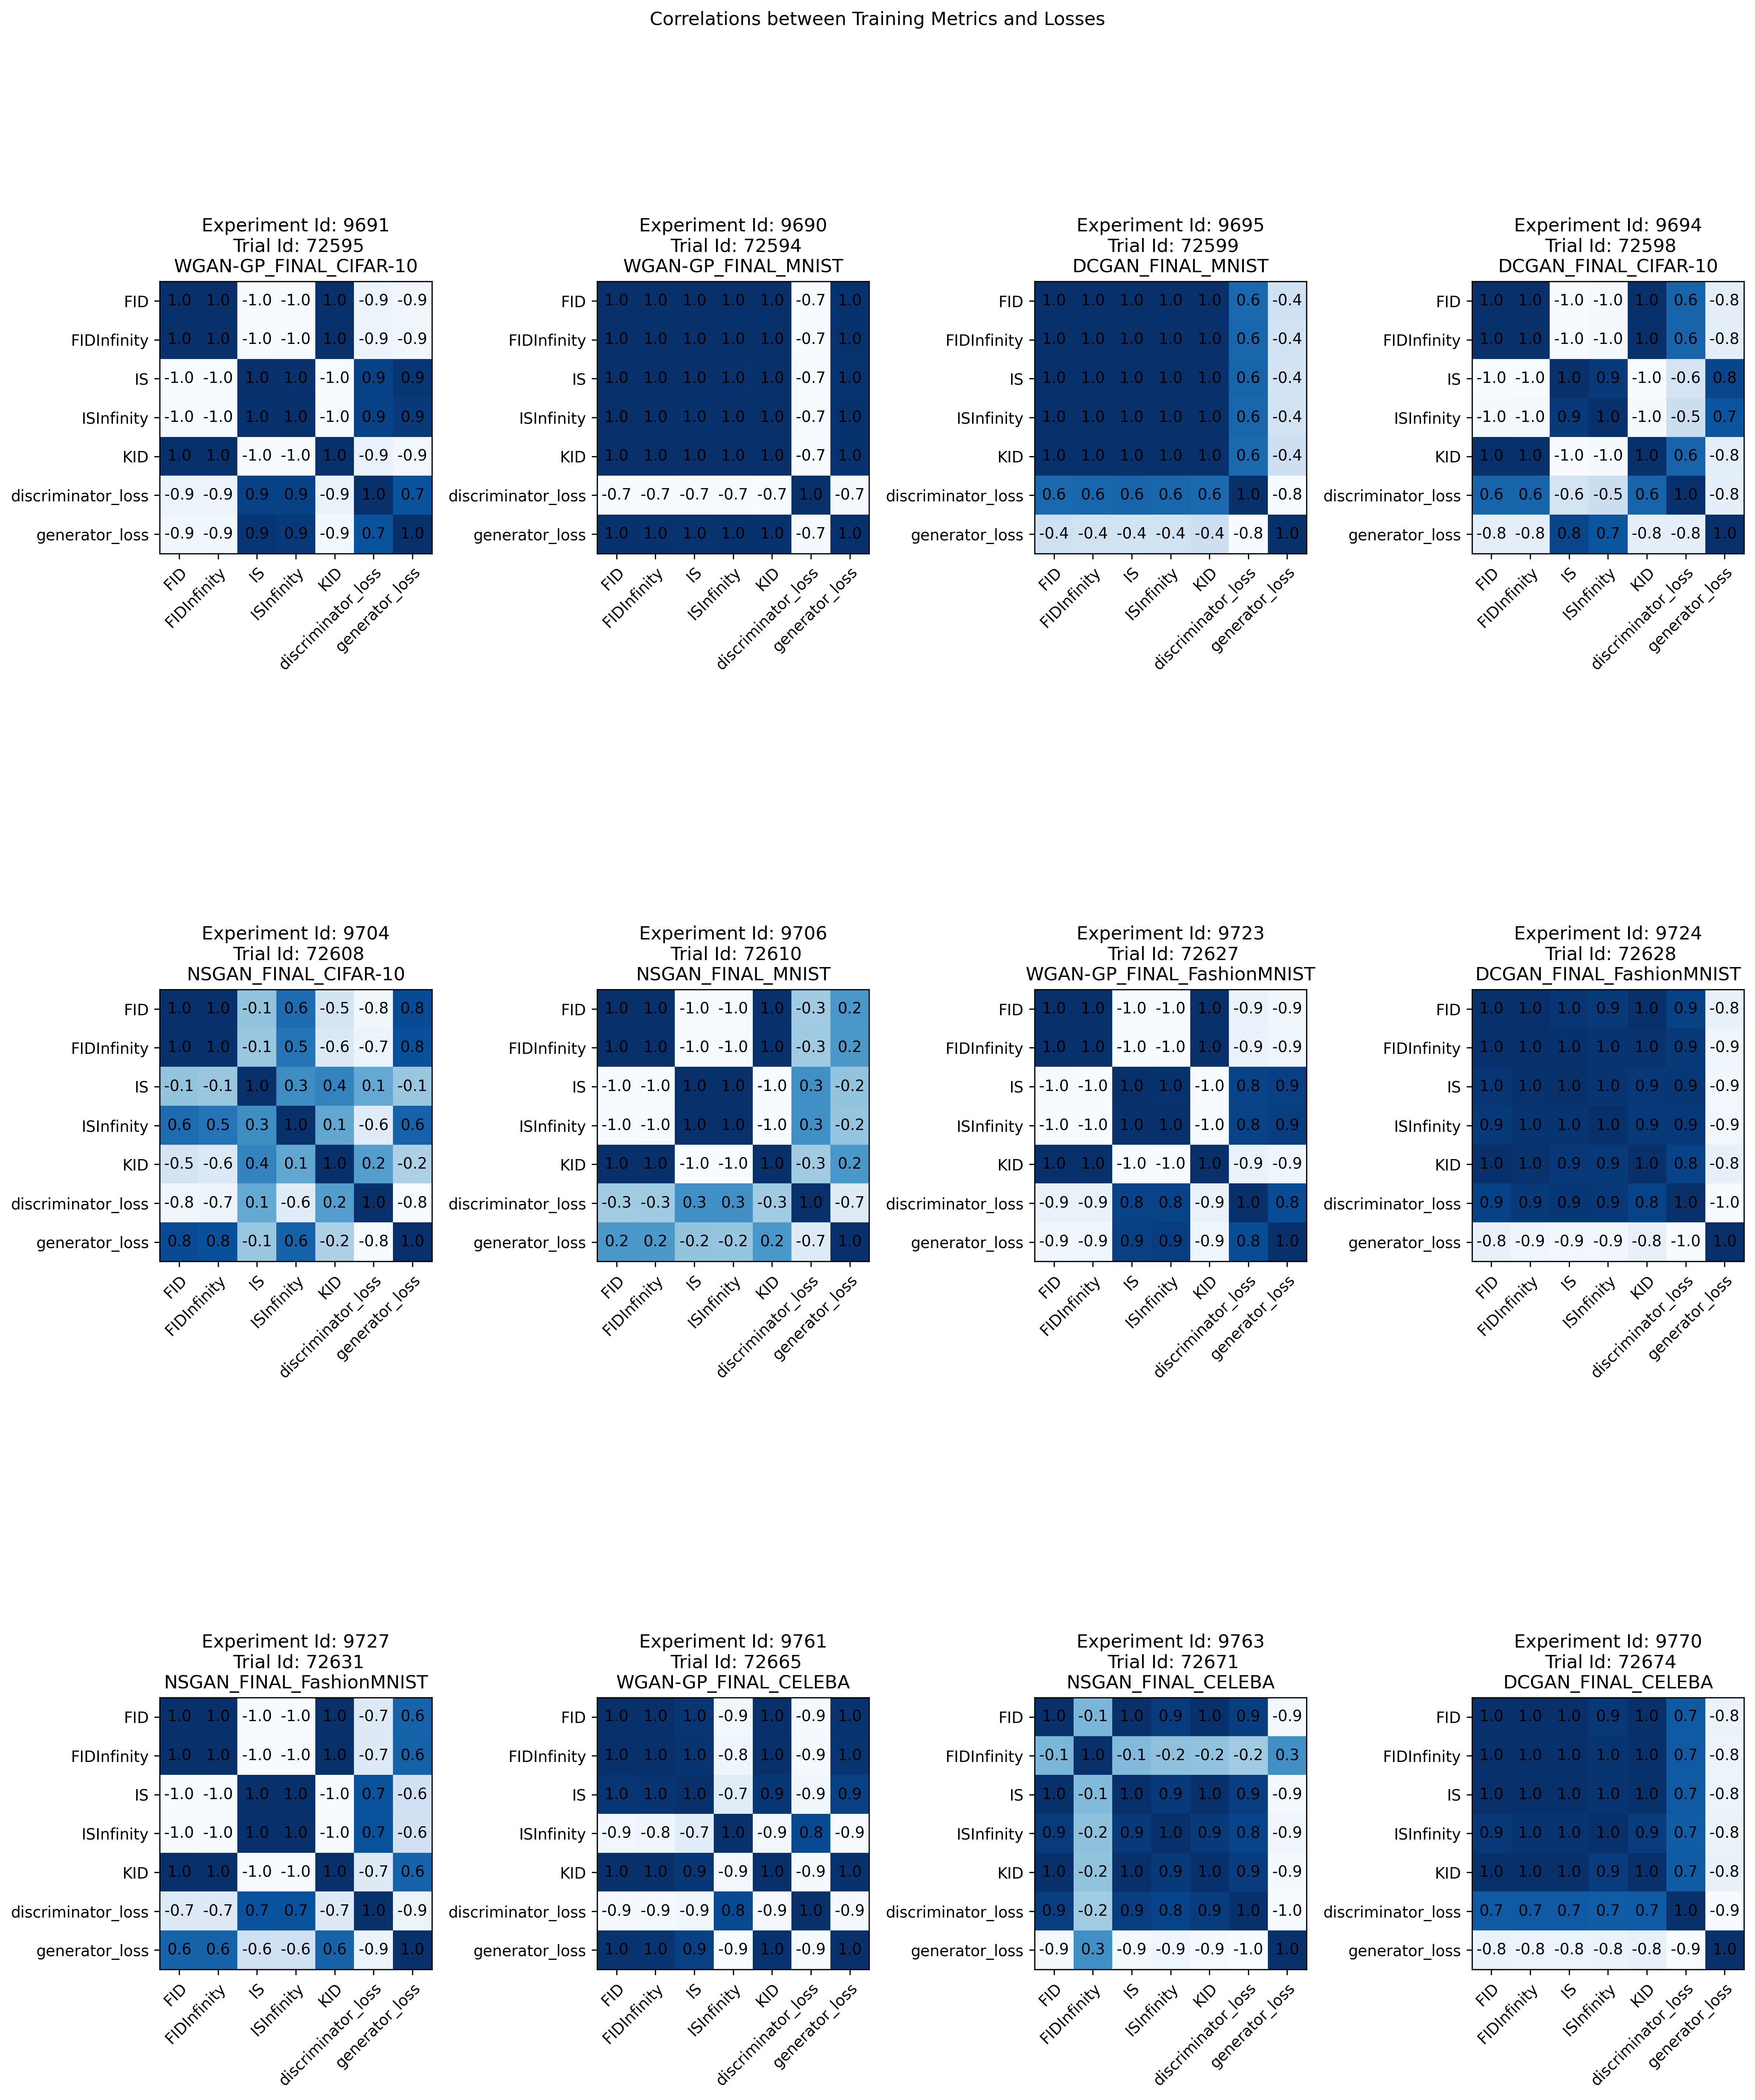

In [23]:
number_of_plots = sum([len(e.trials) for e in experiments])
    
number_of_cols = 4
if number_of_plots > 5:
    number_of_rows = calculate_number_of_rows(number_of_plots, number_of_cols)
else:
    number_of_rows = 5


index = 1
fig = plt.figure(dpi=300)
fig.set_size_inches(16, 20)
#16/20

for e in experiments:
    for t in e.trials:
        metrics = t.training_metrics
        labels = t.training_metric_labels
        
        data = np.array([metric.data for metric in metrics.values()])
        try:
            start_indices = [np.where(d == None)[0] for d in data]
            start_index = np.amax([i[-1] for i in start_indices if len(i) > 0]) + 1
        except:
            start_index = 0

        data = np.corrcoef(np.vstack([metric.data[start_index:] for metric in metrics.values()]))
        #print(data)
        ax = fig.add_subplot(number_of_rows, number_of_cols, index)
        im = ax.imshow(data)
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        # Loop over data dimensions and create text annotations.
        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, "{:.1f}".format(data[i, j]), ha="center", va="center", color="black")


        ax.set_title(f'Experiment Id: {e.experiment_id}\n Trial Id: {t.trial_id}\n{e.name}')
        index = index + 1
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.suptitle(f'Correlations between Training Metrics and Losses', y=1.0025)
fig.tight_layout()

## Evaluation

### Scatter Plot

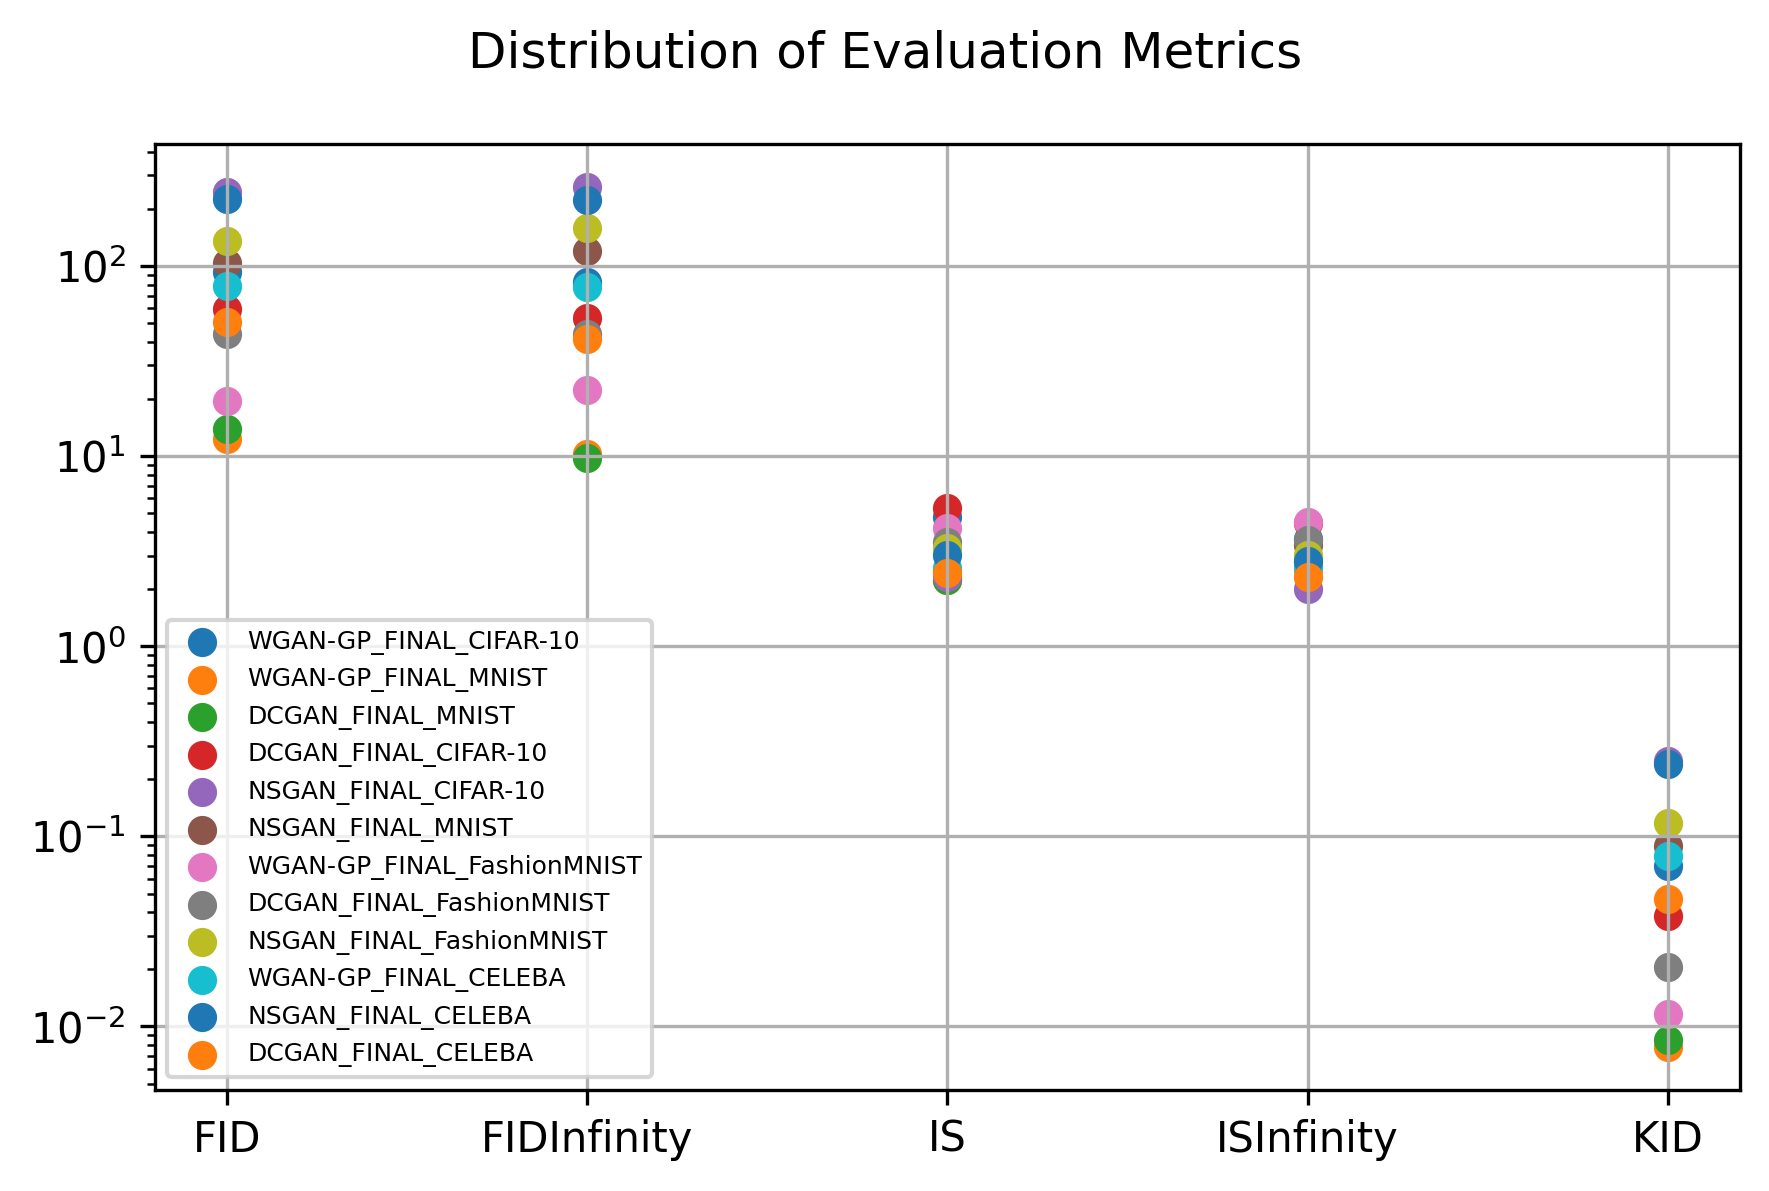

In [24]:
fig = plt.figure(dpi=300)
fig.set_size_inches(6, 4)
index = 1

ax = fig.add_subplot(1, 1, index)
fig.suptitle('Distribution of Evaluation Metrics')
for e in experiments:
    for t in e.trials:
        labels = list(t.validation_metrics.keys())
        values = list(t.validation_metrics.values())
        ax.scatter(labels, values, label=e.name)
        ax.grid(True)
        ax.legend(prop={'size': 6})
        ax.set_yscale('log')
fig.tight_layout()

### Metrics grouped by experiment

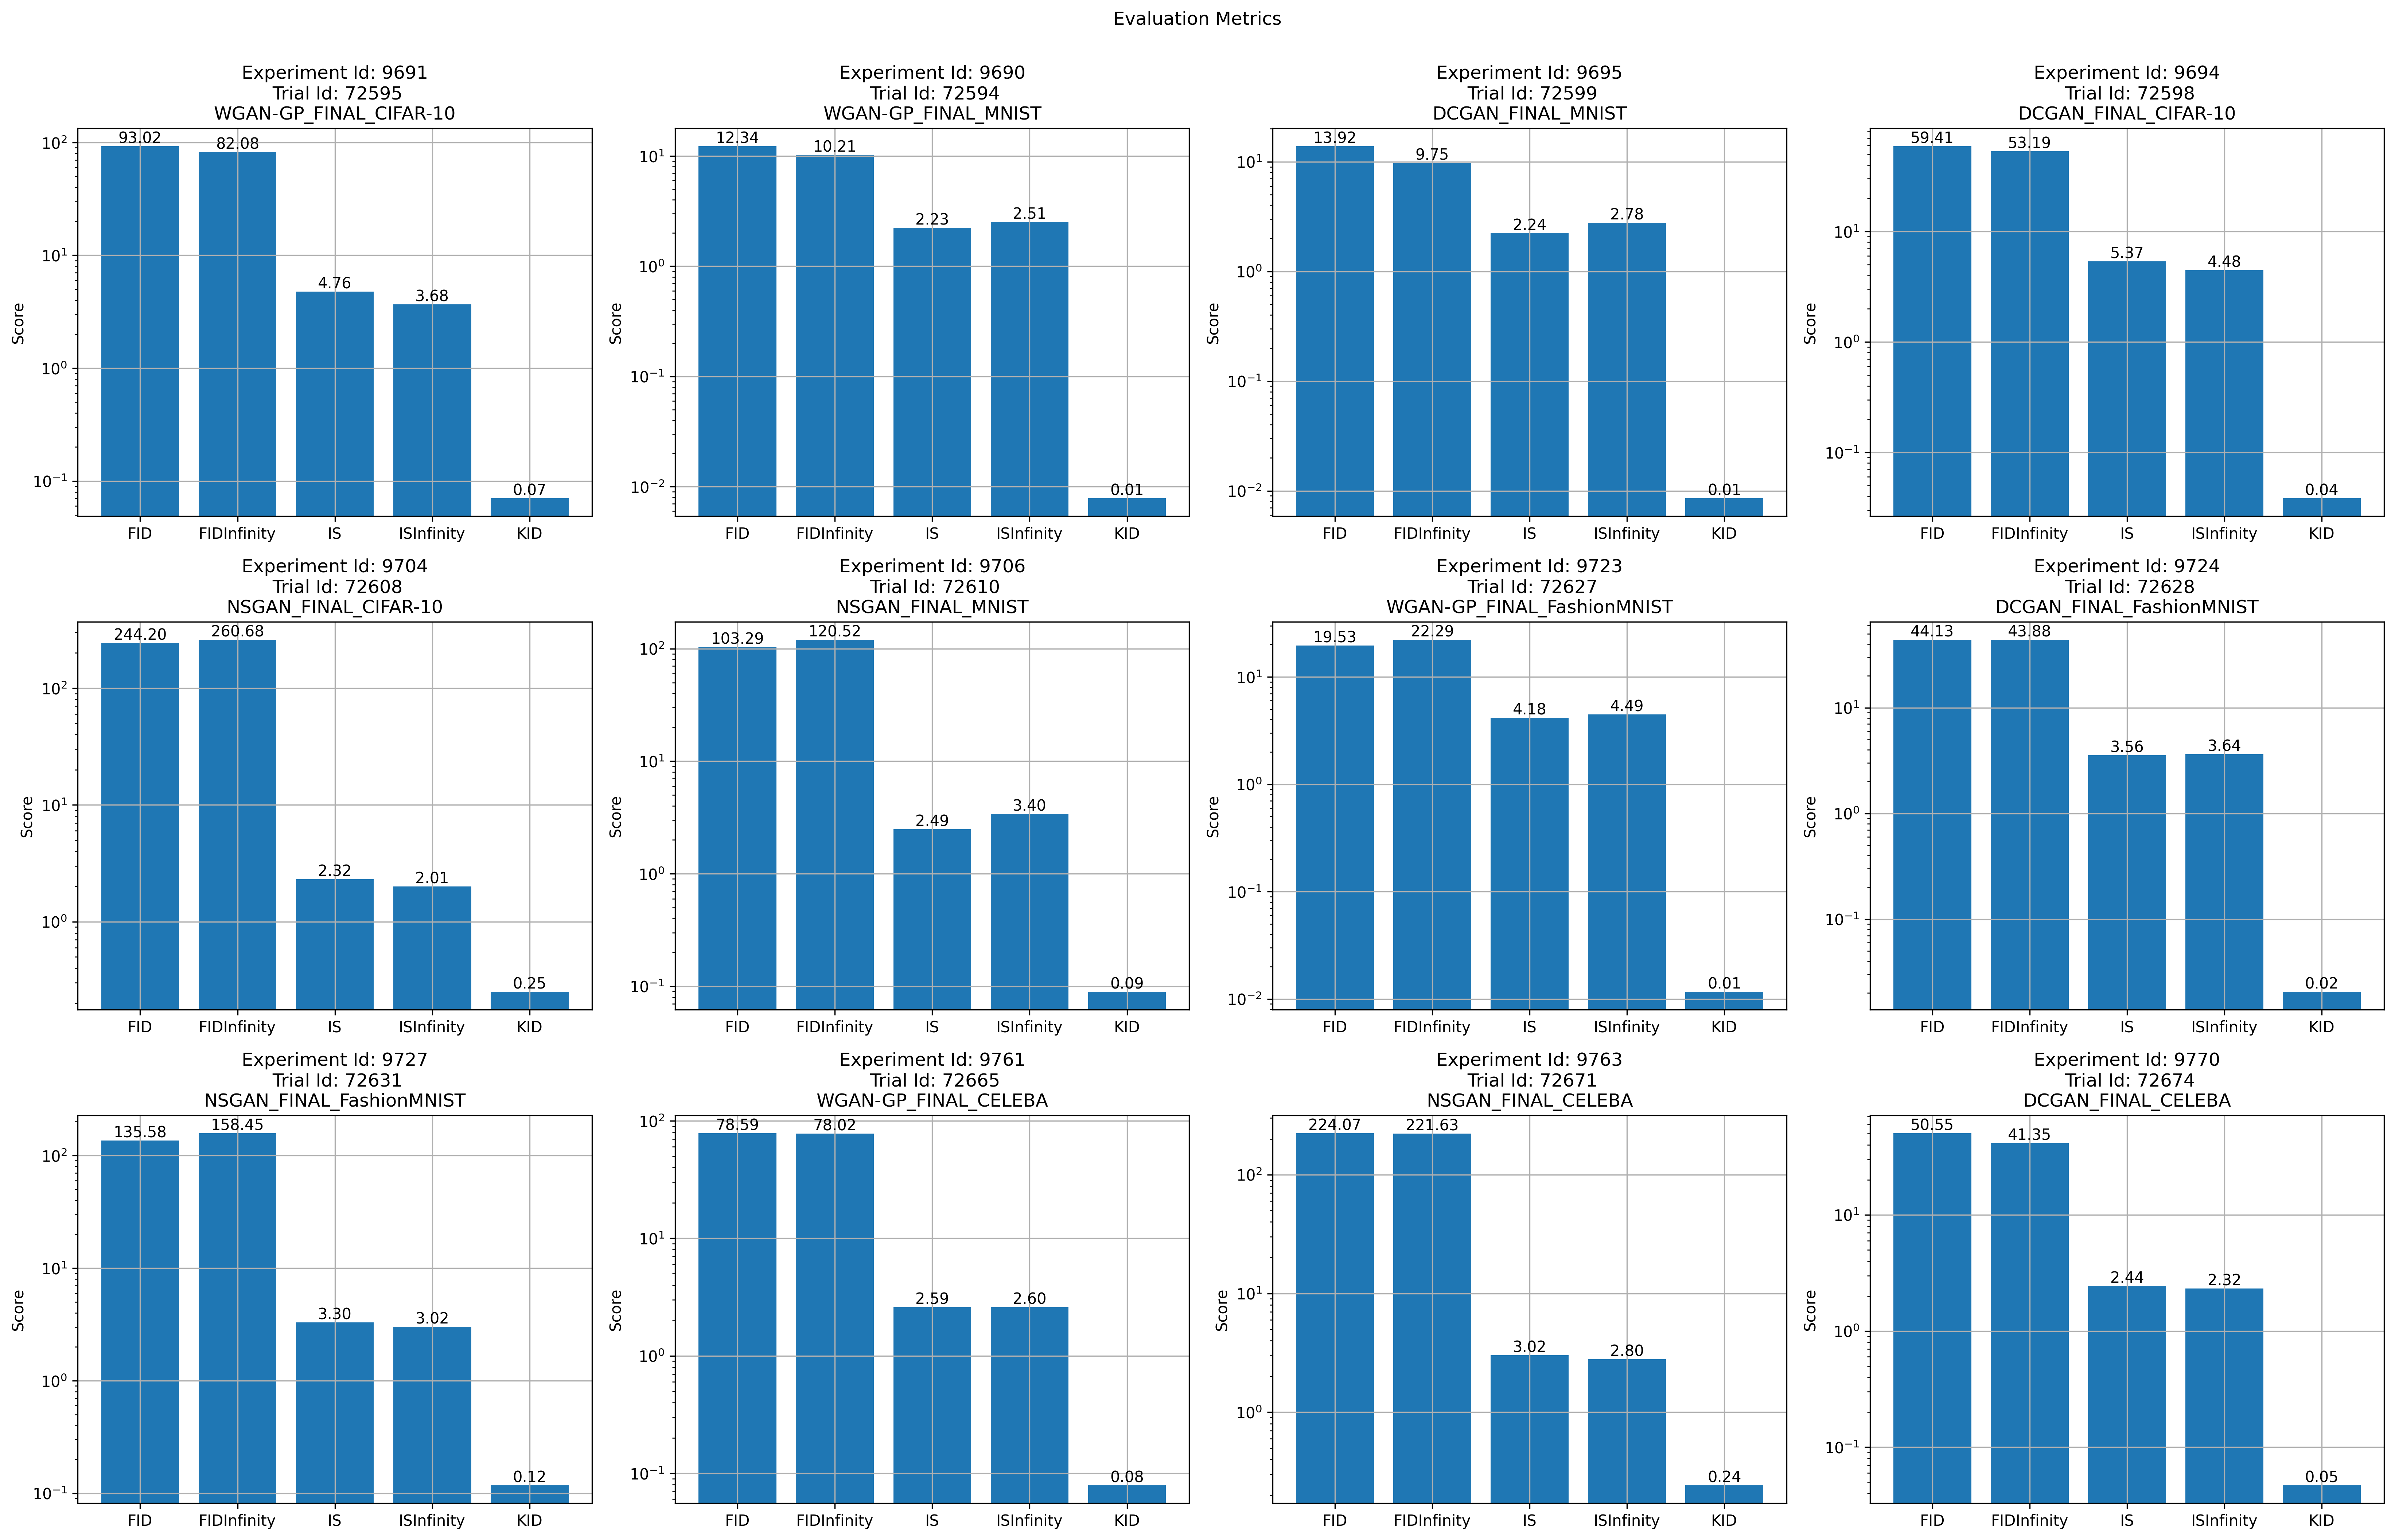

In [25]:
fig = plt.figure(dpi=300)
fig.set_size_inches(22, 14)
index = 1


for e in experiments:
    for t in e.trials:
        labels = list(t.validation_metrics.keys())
        values = list(t.validation_metrics.values())
        ind = np.arange(len(t.validation_metrics))
        ax = fig.add_subplot(number_of_rows, number_of_cols, index)
        bars = ax.bar(ind, values)
        ax.set_ylabel('Score')
        ax.set_title(f'Experiment Id: {e.experiment_id}\n Trial Id: {t.trial_id}\n{e.name}')
        ax.set_xticks(ind)
        ax.set_xticklabels(labels)
        ax.bar_label(bars, fmt='%.2f')
        ax.grid(True)
        ax.set_yscale('log')
        index = index + 1   
        
fig.suptitle('Evaluation Metrics', y=1.0025)
fig.tight_layout()

### Scatterplot of Correlations

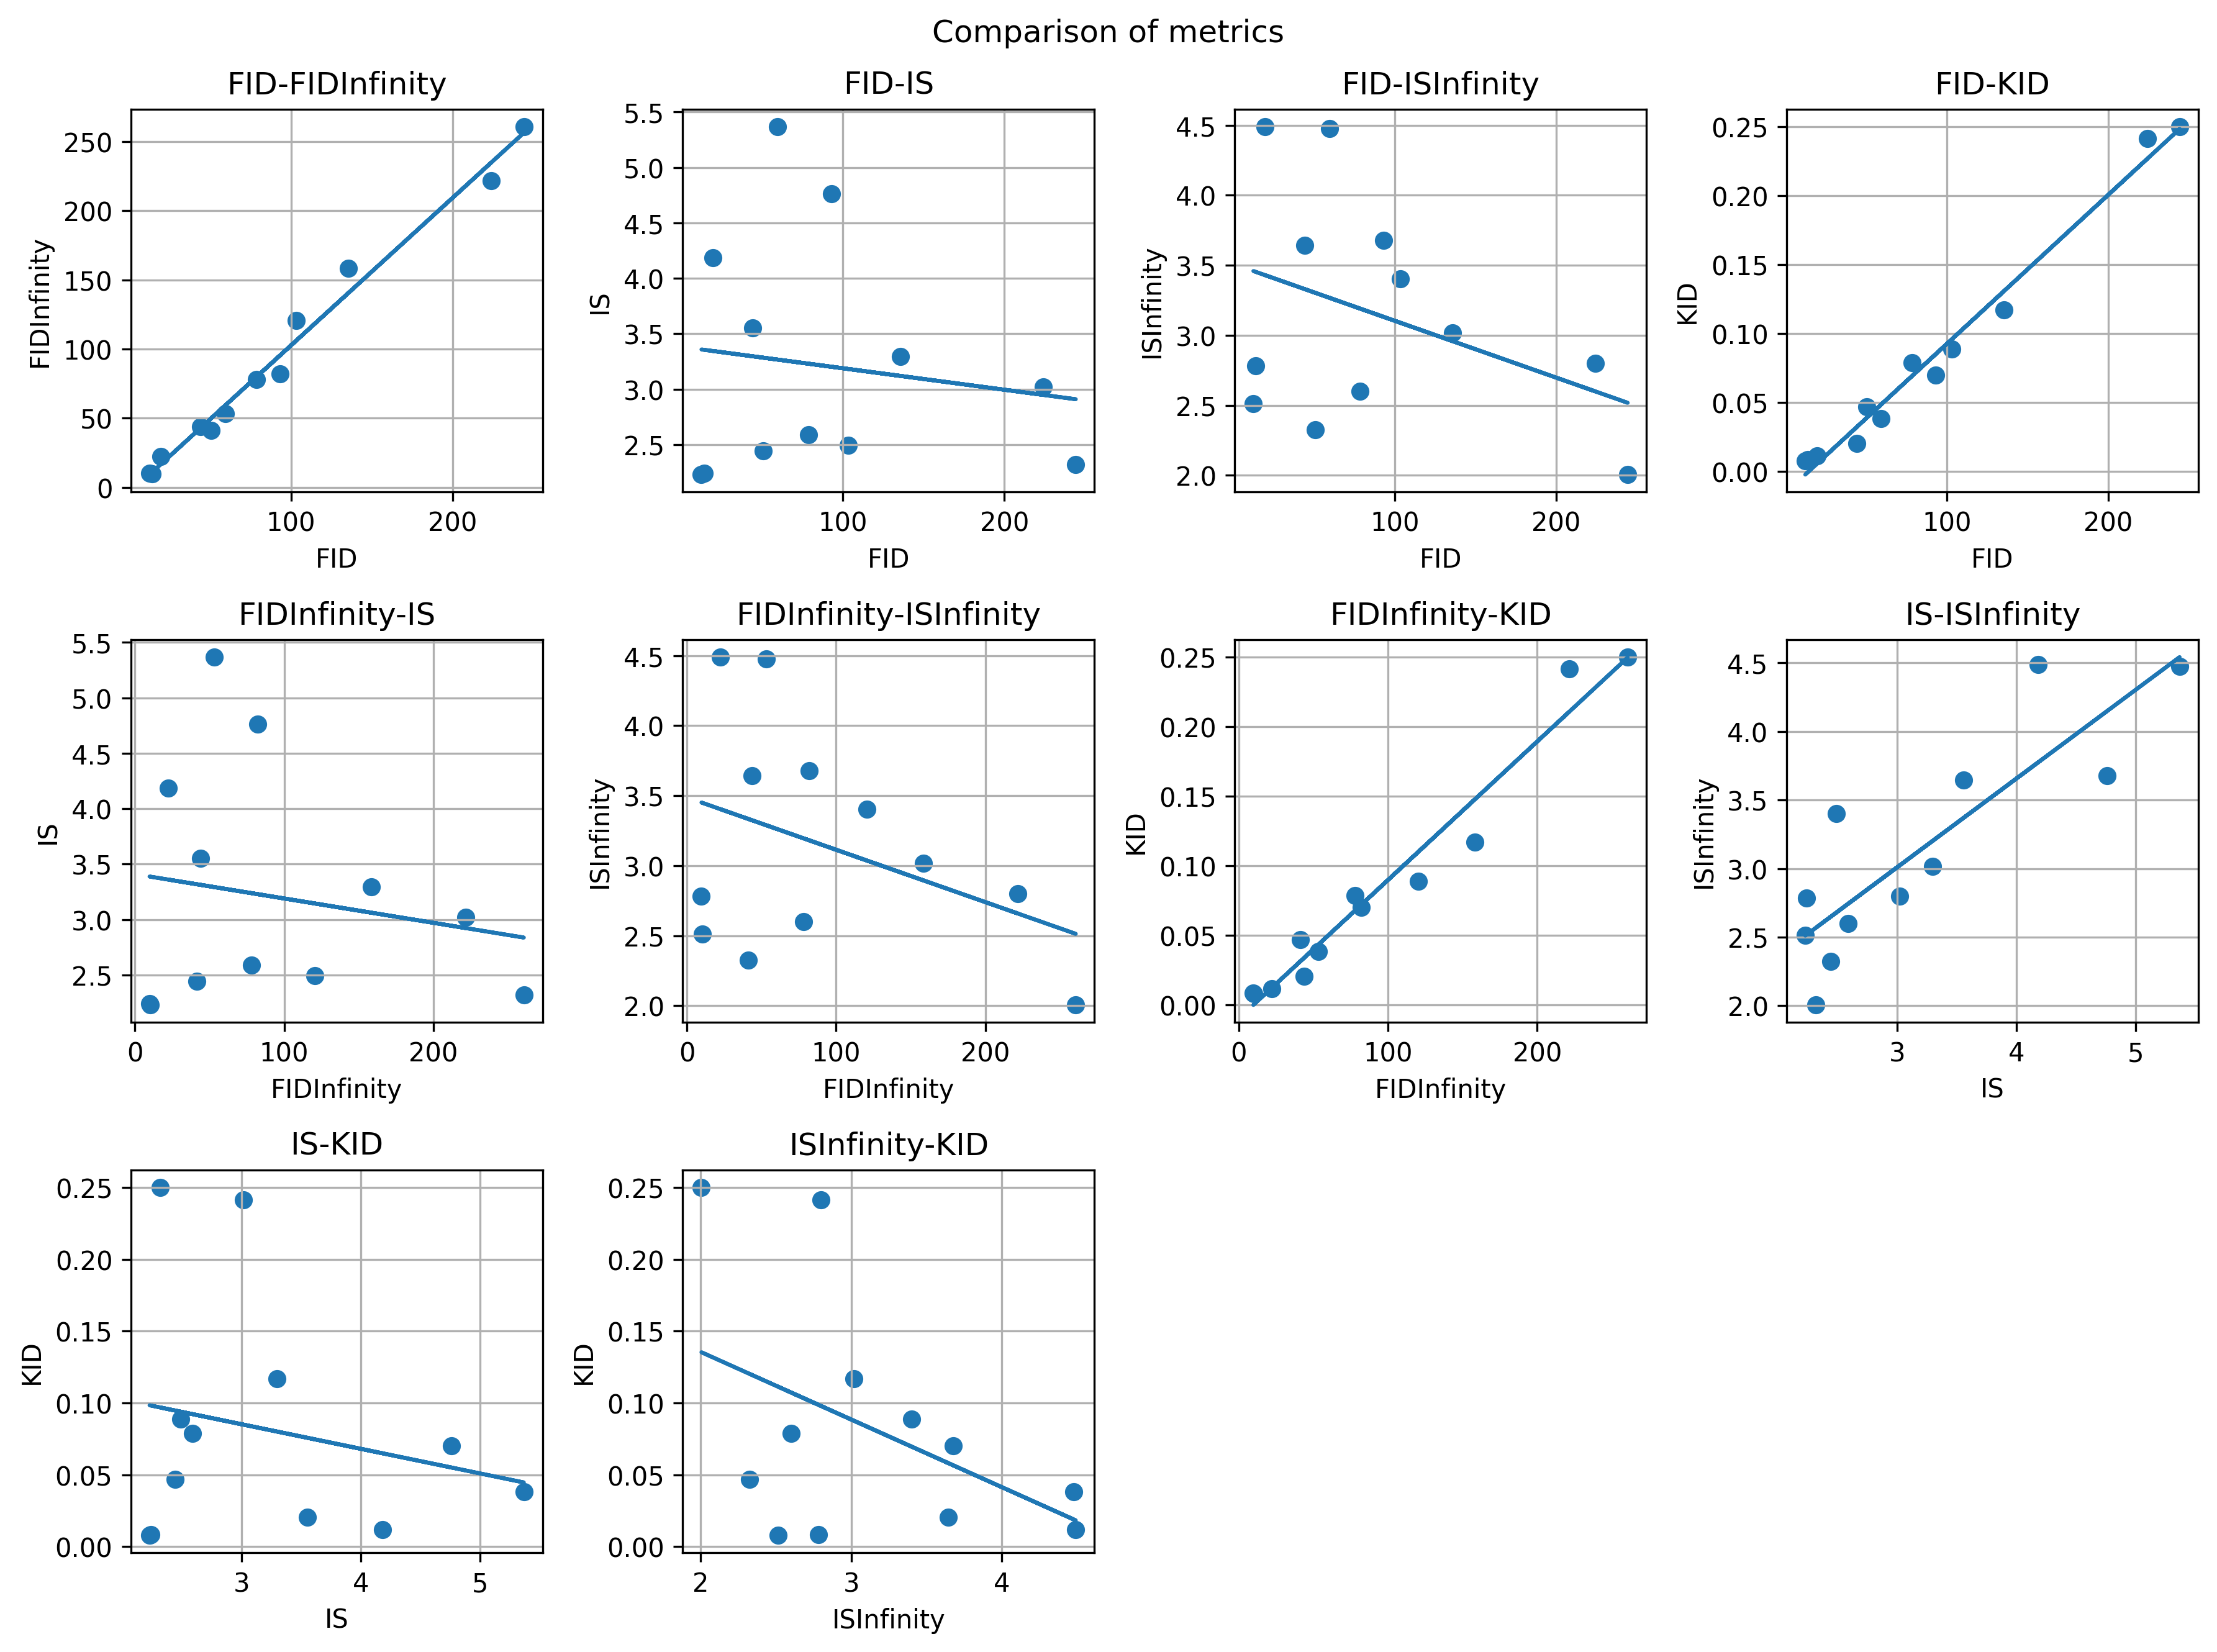

In [26]:
labels = set()
data = dict()

for e in experiments:
    for t in e.trials:
        for l in t.validation_metrics.keys():
            labels.add(l)

            
for e in experiments:
    for t in e.trials:
        for l in t.validation_metrics.keys():
            if l not in data.keys():
                data[l] = list()
            data[l].append(t.validation_metrics[l])


number_of_plots = len(list(combinations(data, 2)))

number_of_cols = 4
if number_of_plots > 5:
    number_of_rows = calculate_number_of_rows(number_of_plots, number_of_cols)
else:
    number_of_rows = 5
    
    
fig = plt.figure(dpi=300)
fig.suptitle(f'Comparison of metrics')
index = 1
for x, y in combinations(data, 2):
    b, m = polyfit(data[x], data[y], 1)
    ax = fig.add_subplot(number_of_rows, number_of_cols, index)
    ax.scatter(data[x], data[y])
    ax.plot(data[x], b + m * np.array(data[x]), '-')
    ax.set(xlabel=x, ylabel=y, title=f'{x}-{y}')
    ax.grid(True)
    index = index + 1

fig.set_size_inches(12, 9)
fig.tight_layout()

### Correlation in Heatmap

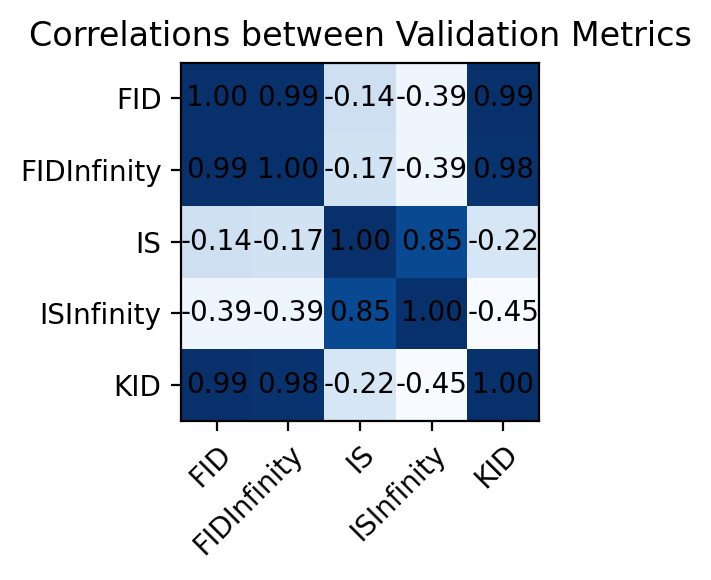

In [27]:
labels = set()
data = dict()

for e in experiments:
    for t in e.trials:
        for l in t.validation_metrics.keys():
            labels.add(l)

            
for e in experiments:
    for t in e.trials:
        for l in t.validation_metrics.keys():
            if l not in data.keys():
                data[l] = list()
            data[l].append(t.validation_metrics[l])


corrs = np.corrcoef(np.vstack(list(data.values())))


fig, ax = plt.subplots(dpi=200)
fig.set_size_inches(3, 3)
im = ax.imshow(corrs)
ax.set_xticks(np.arange(len(data.keys())))
ax.set_yticks(np.arange(len(data.keys())))

ax.set_xticklabels(data.keys())
ax.set_yticklabels(data.keys())

# Loop over data dimensions and create text annotations.
for i in range(len(data.keys())):
    for j in range(len(data.keys())):
        text = ax.text(j, i, "{:.2f}".format(corrs[i, j]),
                       ha="center", va="center", color="black")
        
ax.set_title("Correlations between Validation Metrics")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()      

In [28]:
def t_test(r, n):
    return (r * np.sqrt(n - 2)) / (np.sqrt(1 - r * r))

In [29]:
def calculate_p_value(test_value, dof):
    return 2*(1 - t_dist.cdf(abs(test_value), dof))

In [30]:
calculate_p_value(t_test(r=-0.22, n=12), dof=10)

0.49204531484512315